In [1]:
# Bottom left of interesting area: x,y = (480, 2345)
# Top right of interesting area: x,y = (3341, 327)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.lines as lines
import matplotlib.patches as patches
import numpy as np

In [27]:
def fit_points(p1, p2, bl, tr):
    # Given two points that make a line, make sure those two points are within
    # the box made by bl (bottom left) and tr (top right)
    
    # Get the line of best fit
    coeffs = np.polyfit([p1[0], p2[0]], [p1[1],p2[1]], 1)
    lin = lambda x: x*coeffs[0] + coeffs[1]
    
    # Modify the points so the line is contained within the figure
    
    # Adjust y=values
    if p1[1] > bl[1]:
        a = np.array([[-1*coeffs[0],1],[0,1]])
        b = np.array([coeffs[1],bl[1]])
        s = np.linalg.solve(a,b)
        p1 = (s[0], s[1])

    if p1[1] < tr[1]:
        a = np.array([[-1*coeffs[0],1],[0,1]])
        b = np.array([coeffs[1],tr[1]])
        s = np.linalg.solve(a,b)
        p1 = (s[0], s[1])

    if p2[1] > bl[1]:
        a = np.array([[-1*coeffs[0],1],[0,1]])
        b = np.array([coeffs[1],bl[1]])
        s = np.linalg.solve(a,b)
        p2 = (s[0], s[1])

    if p2[1] < tr[1]:
        a = np.array([[-1*coeffs[0],1],[0,1]])
        b = np.array([coeffs[1],tr[1]])
        s = np.linalg.solve(a,b)
        p2 = (s[0], s[1])
        
    # Adjust x-values
    if p1[0] < bl[0]:
        a = np.array([[-1*coeffs[0],1],[1,0]])
        b = np.array([coeffs[1],bl[0]])
        s = np.linalg.solve(a,b)
        p1 = (s[0], s[1])

    if p1[0] > tr[0]:
        a = np.array([[-1*coeffs[0],1],[1,0]])
        b = np.array([coeffs[1],tr[0]])
        s = np.linalg.solve(a,b)
        p1 = (s[0], s[1])

    if p2[0] < bl[0]:
        a = np.array([[-1*coeffs[0],1],[1,0]])
        b = np.array([coeffs[1],bl[0]])
        s = np.linalg.solve(a,b)
        p2 = (s[0], s[1])

    if p2[0] > tr[0]:
        a = np.array([[-1*coeffs[0],1],[1,0]])
        b = np.array([coeffs[1],tr[0]])
        s = np.linalg.solve(a,b)
        p2 = (s[0], s[1])
    
    return p1, p2

def add_to_plot(fig, ax, img, x, y, section):
    color_str = section[1]
    section_str = section[0]
    
    # Rename on-wedge section
    if section_str == "On wedge":
        section_str = "Wedge"
    
    # Convert data in millimeters to pixels
    x = list(map(lambda x: x_mm_to_px(x), x))
    y = list(map(lambda y: y_mm_to_px(y), y))

    # Plot data points directly as circles
    for i in range(0,len(x)):
        ax.add_artist(patches.Circle((x[i],y[i]), radius = 10, color = color_str, linewidth = 3))

    # Get the line of best fit
    coeffs = np.polyfit(x, y, 1)
    lin = lambda x: x*coeffs[0] + coeffs[1]

    # Get the two points we'll use to plot the line of best fit

    # Initial guess of the points
    p1 = (bl[0], lin(bl[0]))
    p2 = (tr[0], lin(tr[0]))
    
    (p1,p2) = fit_points(p1, p2, bl, tr)
    x = [p1[0], p2[0]]
    y = [p1[1], p2[1]]
    
    if plot_threshold and section_str == threshold_section:
        # Plot rectange showing are being parsed
        # x_min = 50
        # x_max = 100
        # below = 10
        # above = 10
        # bl = (480, 2345)
        # tr = (3341, 327)
        
        bl2 = (x_mm_to_px(x_min),bl[1])
        tr2 = (x_mm_to_px(x_max),tr[1])
        
        # Top line of the rectangle (below is swapped due to image axes)
        p1 = (bl[0], lin(bl[0])+below*(yp/ymm))
        p2 = (tr[0], lin(tr[0])+below*(yp/ymm))
        (p1,p2) = fit_points(p1, p2, bl2, tr2)
        
        # Bottom line of the rectangle (above is swapped due to image axes)
        p3 = (bl[0], lin(bl[0])-above*(yp/ymm))
        p4 = (tr[0], lin(tr[0])-above*(yp/ymm))
        (p3,p4) = fit_points(p3, p4, bl2, tr2)
        
        x_tmp = x
        y_tmp = y
        
        x = [p1[0], p2[0], p4[0], p3[0]]
        y = [p1[1], p2[1], p4[1], p3[1]]
        
        xy = np.transpose(np.array([x,y]))
        
        label_str = "Above " + str(above) + "mm, below " + str(below) + "mm"
        ax.add_artist(patches.Polygon(xy, color="fuchsia", alpha=0.25, label=label_str))
        
        # Place line of best fit over shaded area
        x = x_tmp
        y = y_tmp
    
    # Plot the line of best fit
    ax.add_artist(lines.Line2D(x, y, linewidth=3, color=color_str, label=section_str))
    
    return fig, ax, img, p1, p2

def get_seconds_line_numbers(trial, seconds):
    # Open file
    file = open(base_dir + "trial " + str(trial) + "/raw_data",'r')
    lines = file.readlines()
    
    # Initialize output array, last value is the last line of the file
    arr = [-1,-1,-1,-1,-1,-1,len(lines)-1]
    
    for i in range(0,len(lines)):
        if lines[i].strip() == "10 seconds":
            arr[0] = i;
        elif lines[i].strip() == "11 seconds":
            arr[1] = i;
        elif lines[i].strip() == "12 seconds":
            arr[2] = i;
        elif lines[i].strip() == "13 seconds":
            arr[3] = i;
        elif lines[i].strip() == "14 seconds":
            arr[4] = i;
        elif lines[i].strip() == "15 seconds":
            arr[5] = i;

    file.close()
    
    return arr

def get_data(trial, seconds, field):
    # Output arrays
    x = []
    y = []
    
    # Open file
    file = open(base_dir + "trial " + str(trial) + "/raw_data",'r')
    lines = file.readlines()
    
    # Get line numbers of each section
    sections = get_seconds_line_numbers(trial, seconds)

    section_line = 0;
    # Read each line in the file until we get to what we're interested in
    for i in range(sections[int(seconds)-10],sections[int(seconds)-10+1]):
        if lines[i].strip() == field:
            section_line = i
            
    # Extract data
    for i in range(section_line+1,len(lines)):
        if lines[i].strip() == "":
            break;
        arr = lines[i].strip().split(" ")
        x.append(float(arr[0]))
        y.append(float(arr[1]))
        
    file.close()
    return x,y

def save_angles_to_file(file_name, angles):
    file = open(file_name, 'w')
    content = []
    content.append("Angles in degrees\n")
    content.append("{0: <31s}: {1}\n".format("Harmonic Edge", str(angles[0])))
    content.append("{0: <31s}: {1}\n".format("Soliton Edge", str(angles[1])))
    content.append("{0: <31s}: {1}\n".format("Wedge edge", str(angles[2])))
    content.append("{0: <31s}: {1}\n".format("|Harmonic edge - Soliton edge|", str(abs(angles[0] - angles[1]))))
    content.append("{0: <31s}: {1}\n".format("|Harmonic edge - Wedge|", str(abs(angles[0] - angles[2]))))
    content.append("{0: <31s}: {1}\n".format("|Soliton edge - Wedge|", str(abs(angles[1] - angles[2]))))
    file.writelines(content)
    file.close()
    
def save_lines_to_file(file_name, left_points, right_points):
    file = open(file_name, 'w')
    content = []
    content.append("Lines of best fit\n")
    for i in range(0,len(sections)):
        # Get slope and intercept
        m = (left_points[i][1]-right_points[i][1])/(left_points[i][0]-right_points[i][0])
        b = left_points[i][1]-m*left_points[i][0]
        content.append("{0: <14s}: y={1}x+{2}\n".format(sections[i], m, b))
    file.writelines(content)
    file.close()

# Convert coordinates between mm and px
def x_mm_to_px(x):
    return x*xp/xmm + bl[0]
def y_mm_to_px(y):
    return bl[1] - y*yp/ymm
def x_px_to_mm(x):
    return (xmm/xp)*(x-bl[0])
def y_px_to_mm(y):
    return (ymm/yp)*(bl[1]-y)

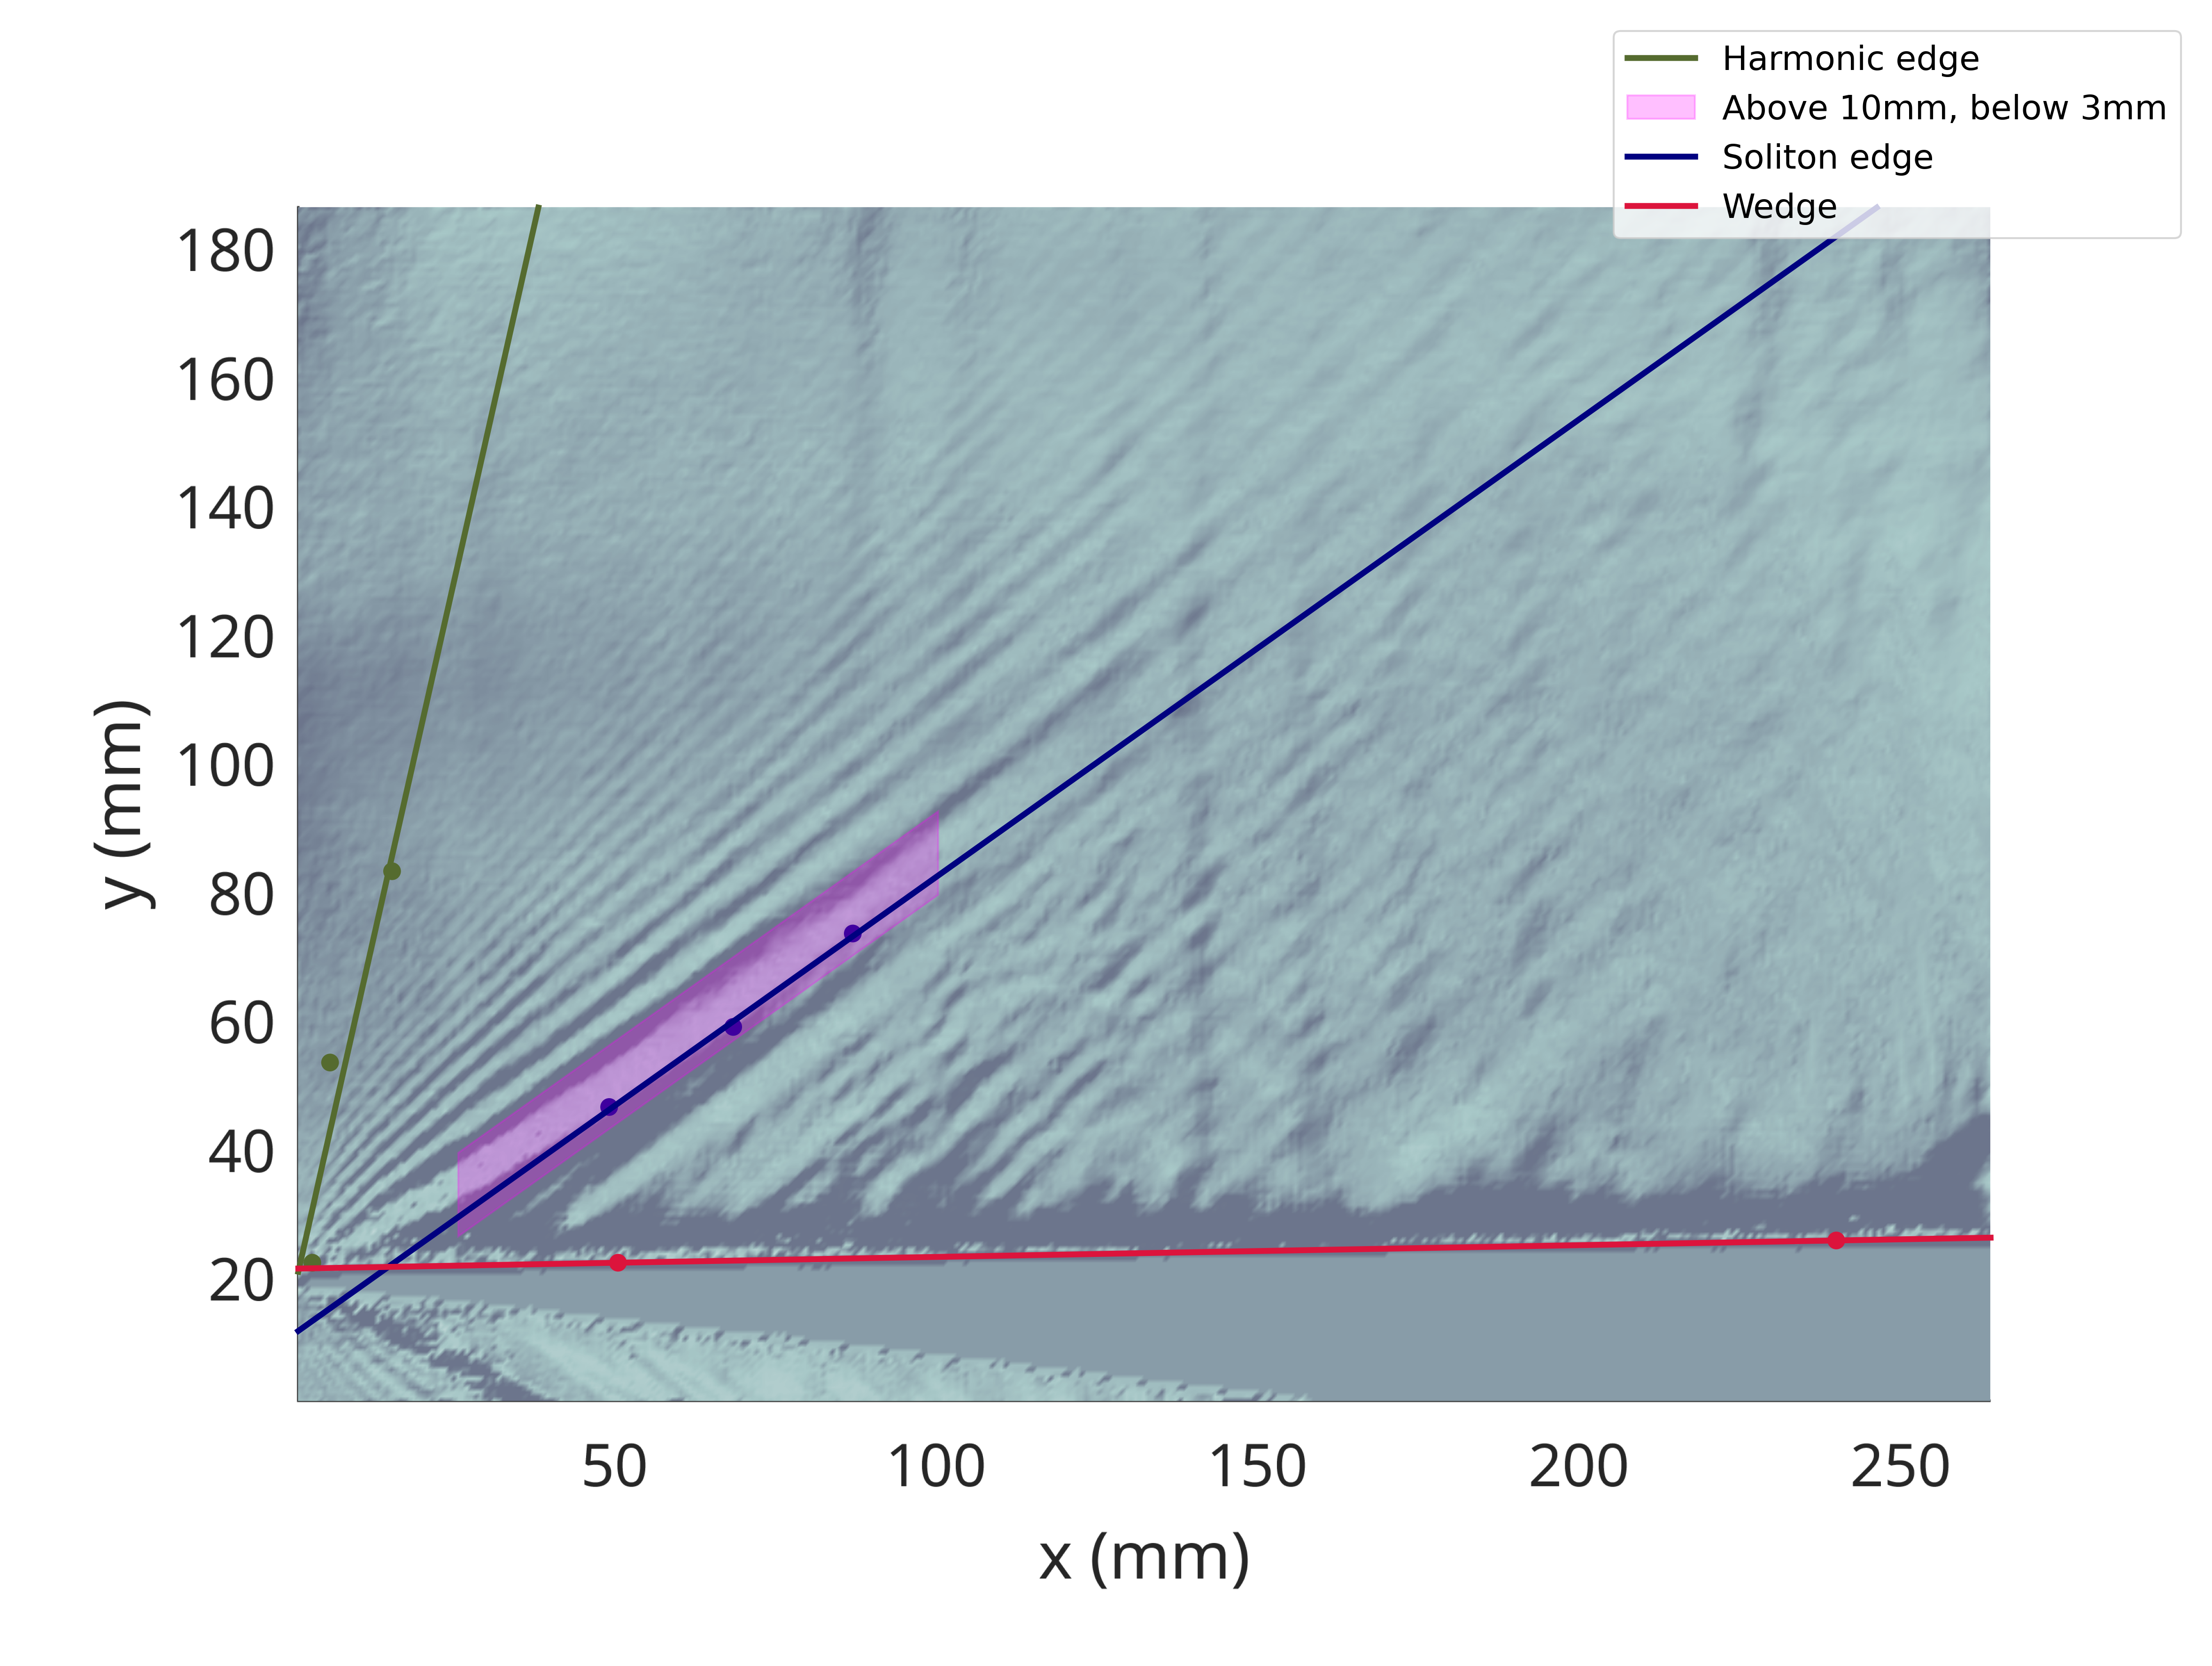

In [30]:
# Corners of the plot area in pixels
bl = (480, 2345)
tr = (3341, 327)

# Size of the plot area in millimeters (axes units)
xmm = 264.4788
ymm = 185.7814

# Size of the plot area in pixels
xp = np.abs(bl[0]-tr[0])
yp = np.abs(bl[1]-tr[1])

# Base directory of experiment
base_dir = "../../Experiment 12/"

# Sections and their colors
sections = ["Harmonic edge", "Soliton edge", "On wedge"]
colors = ["darkolivegreen", "navy", "crimson"]
sections_and_colors = list(zip(sections,colors))

# Optional
save_img = False;
plot_threshold = True;
threshold_section = "Soliton edge"
# Values in mm
x_min = 25
x_max = 100
below = 3
above = 10

for trial in range(2,3):
    for seconds in range(13,14):
        # Make figure which we will modify
        data_file_str = base_dir + "trial " + str(trial) + "/raw_data"
        original_img_str = base_dir + "trial " + str(trial) + "/fsss/original/t" + str(trial) + "_" + str("{0:02}".format(seconds)) + ".png"
        fig, ax = plt.subplots(figsize=(20,16), frameon=False, dpi = 300)
        img = mpimg.imread(original_img_str)
        
        # Save two points for lines of best fit
        left_points = []
        right_points = []

        # Add lines of best fit to plot, saving the points for each line of best fit
        for section in sections_and_colors:
            x,y = get_data(trial, seconds, section[0])
            fig, ax, img, p1, p2 = add_to_plot(fig, ax, img, x, y, section)
            left_points.append(p1)
            right_points.append(p2)

        # Get angles of the lines of best fit and make slope relative to bottom of the image
        angles = []
        for i in range(0,len(left_points)):
            angle = np.rad2deg(np.arctan2(left_points[i][1]-right_points[i][1],left_points[i][0]-right_points[i][0]))
            angles.append(180-angle)

        # Save angles to a file
        angles_str = base_dir + "trial " + str(trial) + "/angles/" + "{0:02}".format(seconds) + ".txt"
        save_angles_to_file(angles_str, angles)
        
        # Save lines of best fit to a file
        # Convert points from pixels to mm
        l2 = list(map(lambda t:  (x_px_to_mm(t[0]),y_px_to_mm(t[1])), left_points))
        r2 = list(map(lambda t:  (x_px_to_mm(t[0]),y_px_to_mm(t[1])), right_points))
        lines_str = base_dir + "trial " + str(trial) + "/lines/" + "{0:02}".format(seconds) + ".txt"
        save_lines_to_file(lines_str, l2, r2)

        # Legend data
        ax.legend(fontsize='xx-large', loc='upper right')
        
        plt.axis('off')
        plt.imshow(img)

        # Save the image
        if plot_threshold:
            location = base_dir +  "trial " + str(trial) + "/fsss/overlay/t" + str(trial) + "_" + str("{0:02}".format(seconds)) + ".png"
        else:
            save_img_str = base_dir +  "trial " + str(trial) + "/fsss/overlay_with_box/t" + str(trial) + "_" + str("{0:02}".format(seconds)) + ".png"
        
        if save_img:
            plt.savefig(save_img_str, pad_inches = 0, bbox_inches='tight')
            plt.close(fig)